In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime

In [2]:
train = pd.read_csv('train_revised.csv')
test = pd.read_csv('test_questions.csv')

In [3]:
test.head()

,ride_id,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity
0,247,2018-05-07,07:06,Kisii,Nairobi,Bus,49
1,256,2018-05-06,11:08,Kisii,Nairobi,shuttle,11
2,275,2018-05-04,05:00,Kisii,Nairobi,shuttle,11
3,285,2018-05-04,09:10,Kisii,Nairobi,shuttle,11
4,286,2018-05-04,09:20,Kisii,Nairobi,shuttle,11


In [4]:
train.head()

,ride_id,seat_number,payment_method,payment_receipt,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity
0,1442,15A,Mpesa,UZUEHCBUSO,17-10-17,7:15,Migori,Nairobi,Bus,49
1,5437,14A,Mpesa,TIHLBUSGTE,19-11-17,7:12,Migori,Nairobi,Bus,49
2,5710,8B,Mpesa,EQX8Q5G19O,26-11-17,7:05,Keroka,Nairobi,Bus,49
3,5777,19A,Mpesa,SGP18CL0ME,27-11-17,7:10,Homa Bay,Nairobi,Bus,49
4,5778,11A,Mpesa,BM97HFRGL9,27-11-17,7:12,Migori,Nairobi,Bus,49


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51645 entries, 0 to 51644
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ride_id          51645 non-null  int64 
 1   seat_number      51645 non-null  object
 2   payment_method   51645 non-null  object
 3   payment_receipt  51645 non-null  object
 4   travel_date      51645 non-null  object
 5   travel_time      51645 non-null  object
 6   travel_from      51645 non-null  object
 7   travel_to        51645 non-null  object
 8   car_type         51645 non-null  object
 9   max_capacity     51645 non-null  int64 
dtypes: int64(2), object(8)
memory usage: 3.9+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1111 entries, 0 to 1110
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ride_id       1111 non-null   int64 
 1   travel_date   1111 non-null   object
 2   travel_time   1111 non-null   object
 3   travel_from   1111 non-null   object
 4   travel_to     1111 non-null   object
 5   car_type      1111 non-null   object
 6   max_capacity  1111 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 60.9+ KB


In [7]:
def clean_data_train(df):
    df['travel_date'] = pd.to_datetime(df['travel_date'], format='%d-%m-%y', errors='coerce')
    df['travel_time'] = pd.to_datetime(df['travel_time'],format='%H:%M', errors='coerce').dt.time
    return df

In [8]:
train = clean_data_train(train)

In [9]:
train.head()

,ride_id,seat_number,payment_method,payment_receipt,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity
0,1442,15A,Mpesa,UZUEHCBUSO,2017-10-17,07:15:00,Migori,Nairobi,Bus,49
1,5437,14A,Mpesa,TIHLBUSGTE,2017-11-19,07:12:00,Migori,Nairobi,Bus,49
2,5710,8B,Mpesa,EQX8Q5G19O,2017-11-26,07:05:00,Keroka,Nairobi,Bus,49
3,5777,19A,Mpesa,SGP18CL0ME,2017-11-27,07:10:00,Homa Bay,Nairobi,Bus,49
4,5778,11A,Mpesa,BM97HFRGL9,2017-11-27,07:12:00,Migori,Nairobi,Bus,49


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51645 entries, 0 to 51644
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ride_id          51645 non-null  int64         
 1   seat_number      51645 non-null  object        
 2   payment_method   51645 non-null  object        
 3   payment_receipt  51645 non-null  object        
 4   travel_date      51645 non-null  datetime64[ns]
 5   travel_time      51645 non-null  object        
 6   travel_from      51645 non-null  object        
 7   travel_to        51645 non-null  object        
 8   car_type         51645 non-null  object        
 9   max_capacity     51645 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 3.9+ MB


In [11]:
def clean_data_test(df):
    df['travel_date'] = pd.to_datetime(test['travel_date'], format='%Y-%m-%d', errors='coerce')
    # Convert travel_time to a time object to remove the default date
    df['travel_time'] = pd.to_datetime(df['travel_time'], format='%H:%M', errors='coerce').dt.time
    return df


In [12]:
test = clean_data_test(test)

In [13]:
test.head()

,ride_id,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity
0,247,2018-05-07,07:06:00,Kisii,Nairobi,Bus,49
1,256,2018-05-06,11:08:00,Kisii,Nairobi,shuttle,11
2,275,2018-05-04,05:00:00,Kisii,Nairobi,shuttle,11
3,285,2018-05-04,09:10:00,Kisii,Nairobi,shuttle,11
4,286,2018-05-04,09:20:00,Kisii,Nairobi,shuttle,11


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51645 entries, 0 to 51644
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ride_id          51645 non-null  int64         
 1   seat_number      51645 non-null  object        
 2   payment_method   51645 non-null  object        
 3   payment_receipt  51645 non-null  object        
 4   travel_date      51645 non-null  datetime64[ns]
 5   travel_time      51645 non-null  object        
 6   travel_from      51645 non-null  object        
 7   travel_to        51645 non-null  object        
 8   car_type         51645 non-null  object        
 9   max_capacity     51645 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 3.9+ MB


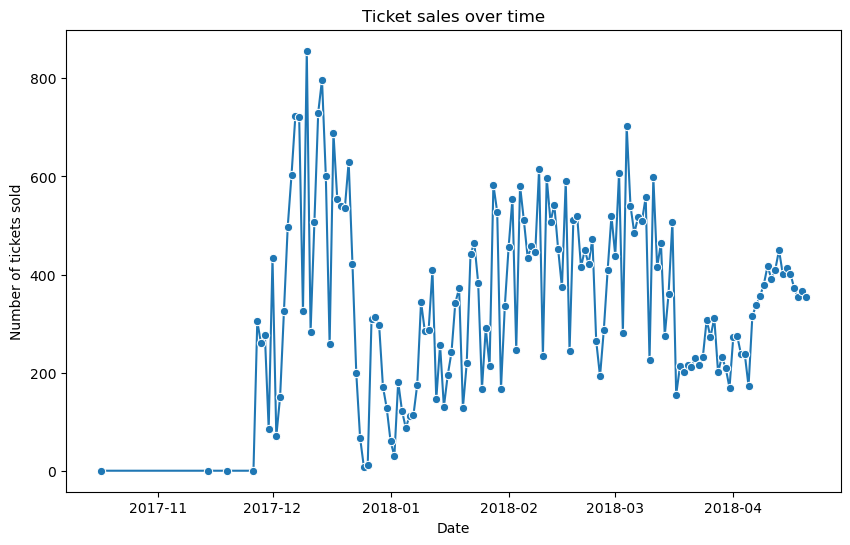

In [14]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=train.groupby('travel_date').size(), marker='o')
plt.title('Ticket sales over time')
plt.xlabel('Date')
plt.ylabel('Number of tickets sold')
plt.show()

C:\Users\Reinhard\AppData\Local\Temp\ipykernel_18756\3935553231.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hourly_ticket_counts.index, y=hourly_ticket_counts.values, palette='viridis')


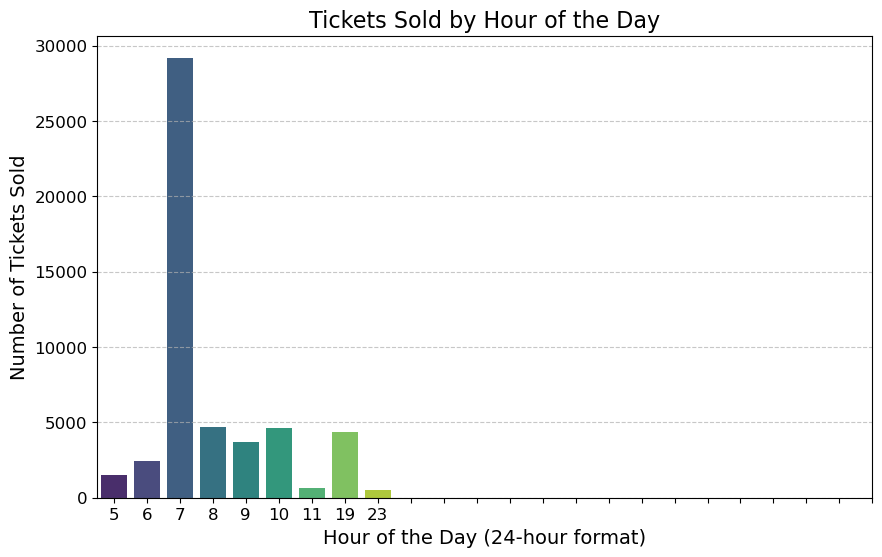

In [ ]:
# Extract the hour from the travel_time column
train['travel_hour'] = pd.to_datetime(train['travel_time'], format='%H:%M:%S').dt.hour

# Group by hour and count the number of tickets sold
hourly_ticket_counts = train.groupby('travel_time').size()

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x=hourly_ticket_counts.index, y=hourly_ticket_counts.values, palette='viridis')
plt.title('Tickets Sold by Hour of the Day', fontsize=16)
plt.xlabel('Hour of the Day (24-hour format)', fontsize=14)
plt.ylabel('Number of Tickets Sold', fontsize=14)
plt.xticks(range(0, 24), fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)


### Feature Engineering

In [15]:
train['total_tickets'] = train.groupby('ride_id')['seat_number'].transform('count')

In [16]:
def feature_engineering(df):
    df['day_of_week'] =  df['travel_date'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x>=5 else 0)
    df['departure_hour'] = pd.to_datetime(df['travel_time'], format='%H:%M:%S').dt.hour
    df['month'] = df['travel_date'].dt.month

    # Cyclical transformations
    #df['hour_sin'] = np.sin(2 * np.pi * df['departure_hour'] / 24)
    #df['hour_cos'] = np.cos(2 * np.pi * df['departure_hour'] / 24)
    #df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    #df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    return df

In [17]:
train = feature_engineering(train)
test = feature_engineering(test)

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51645 entries, 0 to 51644
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ride_id          51645 non-null  int64         
 1   seat_number      51645 non-null  object        
 2   payment_method   51645 non-null  object        
 3   payment_receipt  51645 non-null  object        
 4   travel_date      51645 non-null  datetime64[ns]
 5   travel_time      51645 non-null  object        
 6   travel_from      51645 non-null  object        
 7   travel_to        51645 non-null  object        
 8   car_type         51645 non-null  object        
 9   max_capacity     51645 non-null  int64         
 10  total_tickets    51645 non-null  int64         
 11  day_of_week      51645 non-null  int32         
 12  is_weekend       51645 non-null  int64         
 13  departure_hour   51645 non-null  int32         
 14  month            51645 non-null  int32

In [19]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1111 entries, 0 to 1110
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ride_id         1111 non-null   int64         
 1   travel_date     1111 non-null   datetime64[ns]
 2   travel_time     1111 non-null   object        
 3   travel_from     1111 non-null   object        
 4   travel_to       1111 non-null   object        
 5   car_type        1111 non-null   object        
 6   max_capacity    1111 non-null   int64         
 7   day_of_week     1111 non-null   int32         
 8   is_weekend      1111 non-null   int64         
 9   departure_hour  1111 non-null   int32         
 10  month           1111 non-null   int32         
dtypes: datetime64[ns](1), int32(3), int64(3), object(4)
memory usage: 82.6+ KB


In [ ]:
def add_interaction_features(df):
    # Interaction between travel_from and day_of_week
    df['route_day_interaction'] = df['travel_from'] + '_' + df['day_of_week'].astype(str)

    # Interaction between car_type and departure_hour
    df['car_hour_interaction'] = df['car_type'] + '_' + df['departure_hour'].astype(str)

    return df

# Add interaction features
train = add_interaction_features(train)
test = add_interaction_features(test)

# One-hot encode interaction features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit on training data and transform both datasets
interaction_features = ['route_day_interaction', 'car_hour_interaction']
encoded_train = encoder.fit_transform(train[interaction_features])
encoded_test = encoder.transform(test[interaction_features])

# Convert to DataFrame
encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(interaction_features))
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(interaction_features))

# Merge encoded interaction features with original datasets
train = pd.concat([train.reset_index(drop=True), encoded_train_df], axis=1)
test = pd.concat([test.reset_index(drop=True), encoded_test_df], axis=1)

# Drop original interaction features
train.drop(interaction_features, axis=1, inplace=True)
test.drop(interaction_features, axis=1, inplace=True)

In [48]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51645 entries, 0 to 51644
Columns: 140 entries, ride_id to car_hour_interaction_shuttle_9
dtypes: datetime64[ns](1), float64(125), int32(3), int64(4), object(7)
memory usage: 54.6+ MB


In [20]:
## Encoding categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(train[['travel_from','car_type']])
categories = encoder.get_feature_names_out(['travel_from', 'car_type'])
encoded_df = pd.DataFrame(encoded_features, columns=categories)
train = pd.concat([train.reset_index(drop=True), encoded_df], axis=1)

In [21]:
encoded_test_features = encoder.transform(test[['travel_from', 'car_type']])
encoded_test_df = pd.DataFrame(encoded_test_features, columns= categories)
test = pd.concat([test.reset_index(drop=True), encoded_test_df], axis =1)

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51645 entries, 0 to 51644
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ride_id                51645 non-null  int64         
 1   seat_number            51645 non-null  object        
 2   payment_method         51645 non-null  object        
 3   payment_receipt        51645 non-null  object        
 4   travel_date            51645 non-null  datetime64[ns]
 5   travel_time            51645 non-null  object        
 6   travel_from            51645 non-null  object        
 7   travel_to              51645 non-null  object        
 8   car_type               51645 non-null  object        
 9   max_capacity           51645 non-null  int64         
 10  total_tickets          51645 non-null  int64         
 11  day_of_week            51645 non-null  int32         
 12  is_weekend             51645 non-null  int64         
 13  d

In [23]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1111 entries, 0 to 1110
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ride_id                1111 non-null   int64         
 1   travel_date            1111 non-null   datetime64[ns]
 2   travel_time            1111 non-null   object        
 3   travel_from            1111 non-null   object        
 4   travel_to              1111 non-null   object        
 5   car_type               1111 non-null   object        
 6   max_capacity           1111 non-null   int64         
 7   day_of_week            1111 non-null   int32         
 8   is_weekend             1111 non-null   int64         
 9   departure_hour         1111 non-null   int32         
 10  month                  1111 non-null   int32         
 11  travel_from_Awendo     1111 non-null   float64       
 12  travel_from_Homa Bay   1111 non-null   float64       
 13  tra

In [24]:
train.drop(['ride_id','travel_date','travel_time', 'travel_to','seat_number', 'payment_method', 'payment_receipt', 'travel_from', 'car_type'], axis=1, inplace=True)
test.drop(['travel_from', 'car_type', 'travel_to'], axis=1, inplace=True)


In [26]:
X = train.drop(['total_tickets'], axis=1)
y = train['total_tickets'].reset_index(drop=True)  # Ensure y is a pandas Series


## Time-based Cross-validation

In [30]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Prepare the data
X = train.drop(['total_tickets'], axis=1)
y = train['total_tickets']

# Normalize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# XGBoost does not require feature scaling, so we use the original features for XGBoost
X_original = train.drop(['total_tickets'], axis=1)

# TimeSeriesSplit for cross-validation
ts_split = TimeSeriesSplit(n_splits=5)
mae_scores = []

for train_idx, val_idx in ts_split.split(X_original):
    X_train, X_val = X_original.iloc[train_idx], X_original.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Define and fit the XGBoost model
    xgb_model = xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    # Predict and calculate MAE
    predictions = xgb_model.predict(X_val)
    mae = mean_absolute_error(y_val, predictions)
    mae_scores.append(mae)

print("Mean Absolute Error across folds:", np.mean(mae_scores))

# Fit on the entire training set
xgb_model.fit(X_original, y)

# Prepare test data
X_test = test.drop(['ride_id', 'travel_date', 'travel_time'], axis=1)

# Predict on test data
test['number_of_tickets'] = xgb_model.predict(X_test)

# Save submission
submission = test[['ride_id', 'number_of_tickets']]
submission.to_csv('submission4.csv', index=False)
print("Submission saved!")


Mean Absolute Error across folds: 9.375390343817148
Submission saved!
